In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
with open('SVHN_train.pickle', 'rb') as f:
    tmp_save = pickle.load(f)
    train_dataset_56 = tmp_save['dataset']
    train_labels = tmp_save['labels']
    
valid_size = 2000
valid_dataset_56 = train_dataset_56[:valid_size]
valid_labels = train_labels[:valid_size]
train_dataset_56 = train_dataset_56[valid_size:]
train_labels = train_labels[valid_size:]

with open('SVHN_test.pickle', 'rb') as f:
    tmp_save = pickle.load(f)
    test_dataset_56 = tmp_save['dataset']
    test_labels = tmp_save['labels']
    
print('Training set', train_dataset_56.shape, train_labels.shape)
print('Validation set', valid_dataset_56.shape, valid_labels.shape)
print('Test set', test_dataset_56.shape, test_labels.shape)   

Training set (26149, 56, 56) (26149,)
Validation set (2000, 56, 56) (2000,)
Test set (13068, 56, 56) (13068,)


In [4]:
num_digits = 5
def max_digits(dataset, labels, max_digits):
    keep = [i for i, label in enumerate(labels) if len(label) <= max_digits]
    return dataset[keep], labels[keep]

train_dataset_56, train_labels = max_digits(train_dataset_56, train_labels, 5)
valid_dataset_56, valid_labels = max_digits(valid_dataset_56, valid_labels, 5)
test_dataset_56, test_labels = max_digits(test_dataset_56, test_labels, 5)
print('Training set', train_dataset_56.shape, train_labels.shape)
print('Validation set', valid_dataset_56.shape, valid_labels.shape)
print('Test set', test_dataset_56.shape, test_labels.shape) 

Training set (26149, 56, 56) (26149,)
Validation set (2000, 56, 56) (2000,)
Test set (13068, 56, 56) (13068,)


In [5]:
def show_image(img, label):
    print("Labels", label)
    print("Dtype", img.dtype)
    print("Shape", img.shape)
    print("Color range", np.min(img), np.max(img))
    if len(img.shape) > 2:
        plt.imshow(np.reshape(img, img.shape[:2]))
    else:
        plt.imshow(img)
    plt.show()
    
def show_images(imgs, labels, num=3):
    for i in range(num):
        num = np.random.randint(imgs.shape[0])
        show_image(imgs[num], labels[num])

Labels [1 8 2]
Dtype float32
Shape (56, 56)
Color range -0.492038 0.5


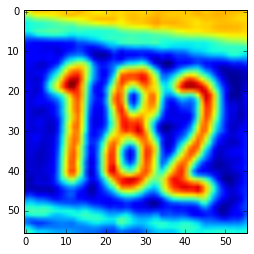

Labels [6 8 2]
Dtype float32
Shape (56, 56)
Color range -0.5 0.5


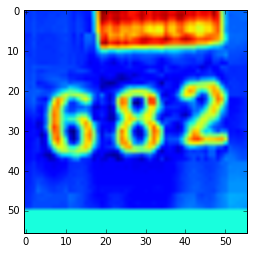

Labels [5 8]
Dtype float32
Shape (56, 56)
Color range -0.517979 0.5


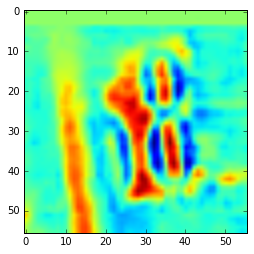

Labels [2 6 4]
Dtype float32
Shape (56, 56)
Color range -0.486017 0.5


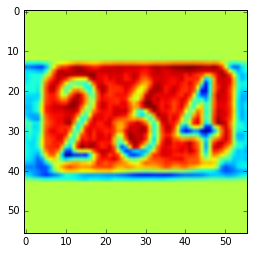

Labels [0]
Dtype float32
Shape (56, 56)
Color range -0.507809 0.5


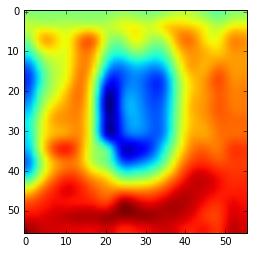

Labels [1 0 2]
Dtype float32
Shape (56, 56)
Color range -0.500192 0.5


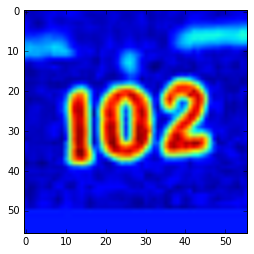

In [6]:
for dataset, labels in [(train_dataset_56, train_labels),
                        (valid_dataset_56, valid_labels),
                        (test_dataset_56, test_labels)]:
    show_images(dataset, labels, 2)

In [7]:
num_labels = 11 # Add an extra character so we can deal with spaces
num_channels = 1 # grayscale

def reformat(dataset, labels):
    dataset_output = dataset.reshape(list(dataset.shape) + [1]).astype(np.float32)
    labels_output = np.array([np.array([(np.arange(num_labels) == l).astype(np.float32) 
                        for l in np.append(row, [num_labels-1] * (num_digits - len(row)), 0)])
              for row in labels])
    return dataset_output, labels_output

train_dataset_56, train_labels = reformat(train_dataset_56, train_labels)
valid_dataset_56, valid_labels = reformat(valid_dataset_56, valid_labels)
test_dataset_56, test_labels = reformat(test_dataset_56, test_labels)

print('Training set', train_dataset_56.shape, train_labels.shape)
print('Validation set', valid_dataset_56.shape, valid_labels.shape)
print('Test set', test_dataset_56.shape, test_labels.shape)

Training set (26149, 56, 56, 1) (26149, 5, 11)
Validation set (2000, 56, 56, 1) (2000, 5, 11)
Test set (13068, 56, 56, 1) (13068, 5, 11)


In [8]:
#Limit test set as it's killing the box
test_dataset_56 = test_dataset_56[:6000]
test_labels = test_labels[:6000]

# Create a pit sized 
train_dataset_28 = train_dataset_56[:, ::2, ::2, :]
valid_dataset_28 = valid_dataset_56[:, ::2, ::2, :]
test_dataset_28 = test_dataset_56[:, ::2, ::2, :]
print('Training set', train_dataset_28.shape, train_labels.shape)
print('Validation set', valid_dataset_28.shape, valid_labels.shape)
print('Test set', test_dataset_28.shape, test_labels.shape)

Training set (26149, 28, 28, 1) (26149, 5, 11)
Validation set (2000, 28, 28, 1) (2000, 5, 11)
Test set (6000, 28, 28, 1) (6000, 5, 11)


In [9]:
dataset_56 = (train_dataset_56, valid_dataset_56, test_dataset_56)
dataset_28 = (train_dataset_28, valid_dataset_28, test_dataset_28)

In [13]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_list(predictions, labels):
    result = np.mean([accuracy(predictions[i],
                               labels[:, i, :])
                        for i in range(num_digits)])
    return result

def run_graph(graph, train_dataset):
    start_time = time.time()
        
    batch_size=16
    
    num_steps = 1000001
    save_steps = 100000
    eval_steps = 500
    valid_steps = 500
    timeout =  2 * 60 # 30 minutes * 60 seconds
        
    tf_train_dataset = graph.get_tensor_by_name('tf_train_dataset:0')
    tf_train_labels = [graph.get_tensor_by_name('tf_train_labels_%d:0' % i) for i in range(num_digits)]
    train_prediction = [graph.get_tensor_by_name('train_prediction_%d:0' % i) for i in range(num_digits)]
    valid_prediction = [graph.get_tensor_by_name('valid_prediction_%d:0' % i) for i in range(num_digits)]
    test_prediction = [graph.get_tensor_by_name('test_prediction_%d:0' % i) for i in range(num_digits)]
    optimizer = graph.get_tensor_by_name('optimizer:0')
    loss = graph.get_tensor_by_name('loss:0')
    learning_rate = graph.get_tensor_by_name('learning_rate:0')
    
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()

        print('Initialized')
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]


            feed_dict = {tf_train_labels[i] : batch_labels[:, i, :] for i in range(num_digits)}
            feed_dict[tf_train_dataset] = batch_data        


            fetches = [optimizer, loss]
            results = session.run(fetches, feed_dict=feed_dict)


            elapsed_time = time.time() - start_time
            timeup = elapsed_time >= timeout
            
            if step > 0 or timeup:
                if (step % eval_steps == 0 or timeup):
                    print('Elapsed time(s):%d/%d (%.2f%%)' % (elapsed_time, timeout, 1.0 * elapsed_time / timeout))
                    if timeup:
                        print("\nTIMEUP!")
                    print('Learning rate:', learning_rate.eval())
                    print('Minibatch loss at step %d: %f' % (step, results[1]))

                    fetches = train_prediction
                    results = session.run(fetches, feed_dict={tf_train_dataset : batch_data})
                    train_accuracy = accuracy_list(
                        results,
                        batch_labels)

                    print('Minibatch accuracy: %.1f%%' % train_accuracy)
            
                if (step % valid_steps == 0 or timeup):
                    valid_accuracy = accuracy_list(
                        [valid_prediction[i].eval() for i in range(num_digits)],
                        valid_labels)
                    print('Validation accuracy: %.1f%%' % valid_accuracy)

                if step % save_steps == 0 or timeup:
                    test_accuracy = accuracy_list(
                        [test_prediction[i].eval() for i in range(num_digits)],
                        test_labels)
                    print('Test accuracy: %.1f%%' % test_accuracy)
                    
            if timeup:
                break

        print("Creating outputs")
    #     output = {
    #         'layer_1' : layer1_weights.eval(),
    #         'layer_2' : layer2_weights.eval(),
    #         'layer_3' : layer3_weights.eval(),
    #     }
    print("Finished")

In [14]:
# This graph will start of simple, and get more complex as we try different inputs
def create_graph(valid_dataset, test_dataset,
                 use_dropout=False,
                 learning_rate=0.05,
                 learning_decay=0.596,
                 use_max_pool=False,
                 num_hidden=64,
                 depth1=16):
    batch_size = 16

    patch_size = 5
    depth = depth1

    # Taken from tensorflow tutorial
    num_hidden = num_hidden

    graph = tf.Graph()
    stddev = 0.1

    img_height, img_width = test_dataset[0].shape[:2]

    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                           img_height,
                                                           img_width,
                                                           num_channels), name="tf_train_dataset")

        tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                             num_labels), name="tf_train_labels_%d" % i)
                           for i in range(num_digits)]

        # Variables.
        layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                        patch_size,
                                                        num_channels,
                                                        depth], stddev=stddev), name="layer1_weights")
        layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

        tmp_size = img_width * img_height * depth
        if use_max_pool: tmp_size = int(tmp_size / 4.)
        layer2_weights = tf.Variable(tf.truncated_normal([tmp_size, num_hidden], stddev=stddev),
                                     name="layer2_weights")
        layer2_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer2_biases")


        layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                        num_labels * num_digits], stddev=stddev), name="layer4_weights")
        layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

        # Model.
        def model(data, dropout=False):
            if dropout: data = tf.nn.dropout(data, 0.9)

            conv = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases)
            if use_max_pool: conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            if dropout: conv = tf.nn.dropout(conv, 0.75)

            shape = conv.get_shape().as_list()
            reshape = tf.reshape(conv, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer2_weights) + layer2_biases)
            if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
            output = tf.matmul(hidden, layer4_weights) + layer4_biases

            split_logits = tf.split(1, num_digits, output)
            return split_logits

        # Training computation.
        logits = model(tf_train_dataset, use_dropout)

        # Training computation.
        logits = model(tf_train_dataset)

        loss = tf.reduce_mean([
                            tf.nn.softmax_cross_entropy_with_logits(
                                logits[i],
                                tf_train_labels[i]
                            )for i in range(num_digits)], name='loss')


        # Optimizer.
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(learning_rate, 
                                                   global_step, 
                                                   100000, 
                                                   learning_decay, 
                                                   name='learning_rate')
        optimizer = tf.train.GradientDescentOptimizer(learning_rate, 
                                                      name='optimizer').minimize(loss, 
                                                                                 global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]
                                         ,name="train_prediction_%d" % i) for i in range(num_digits)]

        tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
        valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]
                                         ,name="valid_prediction_%d" % i) for i in range(num_digits)]

        tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")
        test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]
                                         ,name="test_prediction_%d" % i) for i in range(num_digits)]
    return graph

In [15]:
# Basic
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset) 
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):7/120 (0.07%)
Learning rate: 0.0498705
Minibatch loss at step 500: 1.225587
Minibatch accuracy: 66.2%
Validation accuracy: 62.2%
Elapsed time(s):17/120 (0.15%)
Learning rate: 0.0497417
Minibatch loss at step 1000: 1.232223
Minibatch accuracy: 60.0%
Validation accuracy: 63.1%
Elapsed time(s):26/120 (0.22%)
Learning rate: 0.0496131
Minibatch loss at step 1500: 1.135048
Minibatch accuracy: 66.2%
Validation accuracy: 64.3%
Elapsed time(s):34/120 (0.29%)
Learning rate: 0.0494849
Minibatch loss at step 2000: 1.077468
Minibatch accuracy: 68.8%
Validation accuracy: 65.8%
Elapsed time(s):43/120 (0.36%)
Learning rate: 0.049357
Minibatch loss at step 2500: 0.934738
Minibatch accuracy: 72.5%
Validation accuracy: 67.3%
Elapsed time(s):52/120 (0.43%)
Learning rate: 0.0492295
Minibatch loss at step 3000: 0.900208
Minibatch accuracy: 72.5%
Validation accuracy: 68.2%
Elapsed time(s):61/120 (0.51%)
Learning rate: 0.0491022
Minibatch loss at step 3500: 0.840291
Minibatch accur

In [16]:
# Dropout
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True) 
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):6/120 (0.06%)
Learning rate: 0.0498705
Minibatch loss at step 500: 1.220032
Minibatch accuracy: 66.2%
Validation accuracy: 62.0%
Elapsed time(s):15/120 (0.13%)
Learning rate: 0.0497417
Minibatch loss at step 1000: 1.246236
Minibatch accuracy: 57.5%
Validation accuracy: 63.3%
Elapsed time(s):24/120 (0.21%)
Learning rate: 0.0496131
Minibatch loss at step 1500: 1.065042
Minibatch accuracy: 68.8%
Validation accuracy: 64.6%
Elapsed time(s):35/120 (0.29%)
Learning rate: 0.0494849
Minibatch loss at step 2000: 1.106123
Minibatch accuracy: 66.2%
Validation accuracy: 65.9%
Elapsed time(s):44/120 (0.37%)
Learning rate: 0.049357
Minibatch loss at step 2500: 0.916213
Minibatch accuracy: 71.2%
Validation accuracy: 67.3%
Elapsed time(s):54/120 (0.45%)
Learning rate: 0.0492295
Minibatch loss at step 3000: 0.871221
Minibatch accuracy: 72.5%
Validation accuracy: 68.2%
Elapsed time(s):62/120 (0.52%)
Learning rate: 0.0491022
Minibatch loss at step 3500: 0.874180
Minibatch accur

In [17]:
# Big learning rate
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     learning_rate=0.5) 
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):6/120 (0.06%)
Learning rate: 0.498705
Minibatch loss at step 500: 1.052531
Minibatch accuracy: 72.5%
Validation accuracy: 67.9%
Elapsed time(s):16/120 (0.14%)
Learning rate: 0.497417
Minibatch loss at step 1000: 0.850851
Minibatch accuracy: 81.2%
Validation accuracy: 73.1%
Elapsed time(s):25/120 (0.21%)
Learning rate: 0.496131
Minibatch loss at step 1500: 0.775185
Minibatch accuracy: 82.5%
Validation accuracy: 76.1%
Elapsed time(s):33/120 (0.28%)
Learning rate: 0.494849
Minibatch loss at step 2000: 1.035983
Minibatch accuracy: 86.2%
Validation accuracy: 75.1%
Elapsed time(s):42/120 (0.35%)
Learning rate: 0.49357
Minibatch loss at step 2500: 0.640437
Minibatch accuracy: 90.0%
Validation accuracy: 78.6%
Elapsed time(s):51/120 (0.43%)
Learning rate: 0.492295
Minibatch loss at step 3000: 0.476010
Minibatch accuracy: 96.2%
Validation accuracy: 79.3%
Elapsed time(s):59/120 (0.50%)
Learning rate: 0.491022
Minibatch loss at step 3500: 0.465529
Minibatch accuracy: 92

In [18]:
# Quick decay
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     learning_decay=0.2)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):7/120 (0.06%)
Learning rate: 0.0495985
Minibatch loss at step 500: 1.269386
Minibatch accuracy: 62.5%
Validation accuracy: 62.0%
Elapsed time(s):16/120 (0.14%)
Learning rate: 0.0492009
Minibatch loss at step 1000: 1.317409
Minibatch accuracy: 57.5%
Validation accuracy: 62.6%
Elapsed time(s):26/120 (0.22%)
Learning rate: 0.0488066
Minibatch loss at step 1500: 1.150773
Minibatch accuracy: 62.5%
Validation accuracy: 63.7%
Elapsed time(s):35/120 (0.30%)
Learning rate: 0.0484154
Minibatch loss at step 2000: 1.174429
Minibatch accuracy: 67.5%
Validation accuracy: 64.8%
Elapsed time(s):45/120 (0.38%)
Learning rate: 0.0480274
Minibatch loss at step 2500: 1.007137
Minibatch accuracy: 67.5%
Validation accuracy: 66.7%
Elapsed time(s):54/120 (0.45%)
Learning rate: 0.0476424
Minibatch loss at step 3000: 0.905542
Minibatch accuracy: 72.5%
Validation accuracy: 68.5%
Elapsed time(s):63/120 (0.53%)
Learning rate: 0.0472606
Minibatch loss at step 3500: 0.873129
Minibatch accu

In [19]:
# Big learning rate, quick decay
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     learning_rate=0.5,
                     learning_decay=0.2)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):7/120 (0.06%)
Learning rate: 0.495985
Minibatch loss at step 500: 1.069464
Minibatch accuracy: 73.8%
Validation accuracy: 67.0%
Elapsed time(s):16/120 (0.14%)
Learning rate: 0.492009
Minibatch loss at step 1000: 0.851595
Minibatch accuracy: 83.8%
Validation accuracy: 71.8%
Elapsed time(s):25/120 (0.22%)
Learning rate: 0.488066
Minibatch loss at step 1500: 0.710809
Minibatch accuracy: 83.8%
Validation accuracy: 74.3%
Elapsed time(s):35/120 (0.30%)
Learning rate: 0.484154
Minibatch loss at step 2000: 1.104156
Minibatch accuracy: 86.2%
Validation accuracy: 76.7%
Elapsed time(s):44/120 (0.37%)
Learning rate: 0.480274
Minibatch loss at step 2500: 0.684392
Minibatch accuracy: 85.0%
Validation accuracy: 77.3%
Elapsed time(s):53/120 (0.44%)
Learning rate: 0.476424
Minibatch loss at step 3000: 0.581604
Minibatch accuracy: 95.0%
Validation accuracy: 78.5%
Elapsed time(s):61/120 (0.52%)
Learning rate: 0.472606
Minibatch loss at step 3500: 0.515832
Minibatch accuracy: 9

In [20]:
# Bigger pictures
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     learning_rate=.4)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):7/120 (0.06%)
Learning rate: 0.398964
Minibatch loss at step 500: 1.077254
Minibatch accuracy: 71.2%
Validation accuracy: 66.9%
Elapsed time(s):16/120 (0.13%)
Learning rate: 0.397933
Minibatch loss at step 1000: 0.838482
Minibatch accuracy: 85.0%
Validation accuracy: 73.2%
Elapsed time(s):25/120 (0.22%)
Learning rate: 0.396905
Minibatch loss at step 1500: 0.656494
Minibatch accuracy: 85.0%
Validation accuracy: 75.9%
Elapsed time(s):35/120 (0.29%)
Learning rate: 0.395879
Minibatch loss at step 2000: 1.015541
Minibatch accuracy: 81.2%
Validation accuracy: 78.3%
Elapsed time(s):44/120 (0.37%)
Learning rate: 0.394856
Minibatch loss at step 2500: 0.569933
Minibatch accuracy: 92.5%
Validation accuracy: 78.5%
Elapsed time(s):52/120 (0.44%)
Learning rate: 0.393836
Minibatch loss at step 3000: 0.567121
Minibatch accuracy: 91.2%
Validation accuracy: 79.7%
Elapsed time(s):61/120 (0.51%)
Learning rate: 0.392818
Minibatch loss at step 3500: 0.584612
Minibatch accuracy: 9

In [21]:
# Max pooling
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):5/120 (0.05%)
Learning rate: 0.0498705
Minibatch loss at step 500: 1.221034
Minibatch accuracy: 65.0%
Validation accuracy: 62.6%
Elapsed time(s):13/120 (0.12%)
Learning rate: 0.0497417
Minibatch loss at step 1000: 1.294504
Minibatch accuracy: 58.8%
Validation accuracy: 63.7%
Elapsed time(s):20/120 (0.17%)
Learning rate: 0.0496131
Minibatch loss at step 1500: 1.052132
Minibatch accuracy: 63.8%
Validation accuracy: 65.0%
Elapsed time(s):27/120 (0.23%)
Learning rate: 0.0494849
Minibatch loss at step 2000: 1.151650
Minibatch accuracy: 67.5%
Validation accuracy: 67.2%
Elapsed time(s):34/120 (0.29%)
Learning rate: 0.049357
Minibatch loss at step 2500: 0.912519
Minibatch accuracy: 71.2%
Validation accuracy: 69.0%
Elapsed time(s):41/120 (0.35%)
Learning rate: 0.0492295
Minibatch loss at step 3000: 0.834355
Minibatch accuracy: 75.0%
Validation accuracy: 71.0%
Elapsed time(s):48/120 (0.41%)
Learning rate: 0.0491022
Minibatch loss at step 3500: 0.838932
Minibatch accur

In [22]:
# Max pooling
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.5)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):6/120 (0.05%)
Learning rate: 0.498705
Minibatch loss at step 500: 0.977251
Minibatch accuracy: 75.0%
Validation accuracy: 69.7%
Elapsed time(s):13/120 (0.11%)
Learning rate: 0.497417
Minibatch loss at step 1000: 0.815962
Minibatch accuracy: 85.0%
Validation accuracy: 75.3%
Elapsed time(s):21/120 (0.18%)
Learning rate: 0.496131
Minibatch loss at step 1500: 0.586417
Minibatch accuracy: 91.2%
Validation accuracy: 78.5%
Elapsed time(s):29/120 (0.24%)
Learning rate: 0.494849
Minibatch loss at step 2000: 0.983035
Minibatch accuracy: 91.2%
Validation accuracy: 77.2%
Elapsed time(s):37/120 (0.31%)
Learning rate: 0.49357
Minibatch loss at step 2500: 0.480683
Minibatch accuracy: 93.8%
Validation accuracy: 81.5%
Elapsed time(s):44/120 (0.37%)
Learning rate: 0.492295
Minibatch loss at step 3000: 0.367188
Minibatch accuracy: 96.2%
Validation accuracy: 82.3%
Elapsed time(s):51/120 (0.43%)
Learning rate: 0.491022
Minibatch loss at step 3500: 0.457990
Minibatch accuracy: 92

In [23]:
# Max pooling
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.75)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):5/120 (0.04%)
Learning rate: 0.748058
Minibatch loss at step 500: 0.921746
Minibatch accuracy: 82.5%
Validation accuracy: 71.6%
Elapsed time(s):11/120 (0.10%)
Learning rate: 0.746125
Minibatch loss at step 1000: 0.799633
Minibatch accuracy: 86.2%
Validation accuracy: 76.3%
Elapsed time(s):18/120 (0.16%)
Learning rate: 0.744197
Minibatch loss at step 1500: 0.682101
Minibatch accuracy: 87.5%
Validation accuracy: 77.9%
Elapsed time(s):25/120 (0.22%)
Learning rate: 0.742274
Minibatch loss at step 2000: 0.969504
Minibatch accuracy: 83.8%
Validation accuracy: 77.8%
Elapsed time(s):32/120 (0.27%)
Learning rate: 0.740355
Minibatch loss at step 2500: 0.537112
Minibatch accuracy: 95.0%
Validation accuracy: 80.0%
Elapsed time(s):39/120 (0.33%)
Learning rate: 0.738442
Minibatch loss at step 3000: 0.693974
Minibatch accuracy: 93.8%
Validation accuracy: 80.4%
Elapsed time(s):46/120 (0.39%)
Learning rate: 0.736534
Minibatch loss at step 3500: 0.475306
Minibatch accuracy: 9

In [24]:
# Max pooling
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.25)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):5/120 (0.05%)
Learning rate: 0.249353
Minibatch loss at step 500: 1.071110
Minibatch accuracy: 72.5%
Validation accuracy: 66.0%
Elapsed time(s):12/120 (0.11%)
Learning rate: 0.248708
Minibatch loss at step 1000: 0.946005
Minibatch accuracy: 77.5%
Validation accuracy: 72.5%
Elapsed time(s):19/120 (0.16%)
Learning rate: 0.248066
Minibatch loss at step 1500: 0.658148
Minibatch accuracy: 87.5%
Validation accuracy: 77.3%
Elapsed time(s):27/120 (0.23%)
Learning rate: 0.247424
Minibatch loss at step 2000: 0.933514
Minibatch accuracy: 82.5%
Validation accuracy: 78.3%
Elapsed time(s):34/120 (0.29%)
Learning rate: 0.246785
Minibatch loss at step 2500: 0.582853
Minibatch accuracy: 91.2%
Validation accuracy: 80.5%
Elapsed time(s):41/120 (0.34%)
Learning rate: 0.246147
Minibatch loss at step 3000: 0.459962
Minibatch accuracy: 91.2%
Validation accuracy: 81.5%
Elapsed time(s):47/120 (0.40%)
Learning rate: 0.245511
Minibatch loss at step 3500: 0.449497
Minibatch accuracy: 9

In [25]:
# Max pooling
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.125)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):5/120 (0.04%)
Learning rate: 0.124676
Minibatch loss at step 500: 1.167944
Minibatch accuracy: 65.0%
Validation accuracy: 63.4%
Elapsed time(s):12/120 (0.10%)
Learning rate: 0.124354
Minibatch loss at step 1000: 1.141360
Minibatch accuracy: 73.8%
Validation accuracy: 67.3%
Elapsed time(s):19/120 (0.16%)
Learning rate: 0.124033
Minibatch loss at step 1500: 0.870207
Minibatch accuracy: 77.5%
Validation accuracy: 71.2%
Elapsed time(s):26/120 (0.22%)
Learning rate: 0.123712
Minibatch loss at step 2000: 1.081613
Minibatch accuracy: 76.2%
Validation accuracy: 72.3%
Elapsed time(s):33/120 (0.28%)
Learning rate: 0.123393
Minibatch loss at step 2500: 0.760702
Minibatch accuracy: 78.8%
Validation accuracy: 76.3%
Elapsed time(s):40/120 (0.33%)
Learning rate: 0.123074
Minibatch loss at step 3000: 0.529162
Minibatch accuracy: 88.8%
Validation accuracy: 78.4%
Elapsed time(s):47/120 (0.39%)
Learning rate: 0.122756
Minibatch loss at step 3500: 0.557458
Minibatch accuracy: 8

In [26]:
# num hidden
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.25,
                     num_hidden=128)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):6/120 (0.05%)
Learning rate: 0.249353
Minibatch loss at step 500: 1.048884
Minibatch accuracy: 72.5%
Validation accuracy: 67.1%
Elapsed time(s):14/120 (0.12%)
Learning rate: 0.248708
Minibatch loss at step 1000: 0.844447
Minibatch accuracy: 82.5%
Validation accuracy: 74.0%
Elapsed time(s):23/120 (0.19%)
Learning rate: 0.248066
Minibatch loss at step 1500: 0.650287
Minibatch accuracy: 85.0%
Validation accuracy: 77.7%
Elapsed time(s):31/120 (0.26%)
Learning rate: 0.247424
Minibatch loss at step 2000: 0.979730
Minibatch accuracy: 88.8%
Validation accuracy: 79.3%
Elapsed time(s):39/120 (0.33%)
Learning rate: 0.246785
Minibatch loss at step 2500: 0.555368
Minibatch accuracy: 90.0%
Validation accuracy: 80.8%
Elapsed time(s):46/120 (0.39%)
Learning rate: 0.246147
Minibatch loss at step 3000: 0.440656
Minibatch accuracy: 96.2%
Validation accuracy: 82.2%
Elapsed time(s):54/120 (0.45%)
Learning rate: 0.245511
Minibatch loss at step 3500: 0.367568
Minibatch accuracy: 9

In [27]:
# num hidden
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.25,
                     num_hidden=32)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):5/120 (0.04%)
Learning rate: 0.249353
Minibatch loss at step 500: 1.095914
Minibatch accuracy: 68.8%
Validation accuracy: 64.0%
Elapsed time(s):11/120 (0.10%)
Learning rate: 0.248708
Minibatch loss at step 1000: 1.045650
Minibatch accuracy: 72.5%
Validation accuracy: 70.0%
Elapsed time(s):18/120 (0.16%)
Learning rate: 0.248066
Minibatch loss at step 1500: 0.798501
Minibatch accuracy: 82.5%
Validation accuracy: 74.6%
Elapsed time(s):25/120 (0.22%)
Learning rate: 0.247424
Minibatch loss at step 2000: 1.021132
Minibatch accuracy: 82.5%
Validation accuracy: 75.5%
Elapsed time(s):33/120 (0.28%)
Learning rate: 0.246785
Minibatch loss at step 2500: 0.707284
Minibatch accuracy: 80.0%
Validation accuracy: 78.9%
Elapsed time(s):40/120 (0.34%)
Learning rate: 0.246147
Minibatch loss at step 3000: 0.568260
Minibatch accuracy: 91.2%
Validation accuracy: 79.4%
Elapsed time(s):47/120 (0.39%)
Learning rate: 0.245511
Minibatch loss at step 3500: 0.534903
Minibatch accuracy: 8

In [28]:
# num hidden
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.25,
                     num_hidden=256)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):8/120 (0.07%)
Learning rate: 0.249353
Minibatch loss at step 500: 1.057905
Minibatch accuracy: 73.8%
Validation accuracy: 68.7%
Elapsed time(s):17/120 (0.15%)
Learning rate: 0.248708
Minibatch loss at step 1000: 0.852172
Minibatch accuracy: 86.2%
Validation accuracy: 75.0%
Elapsed time(s):26/120 (0.22%)
Learning rate: 0.248066
Minibatch loss at step 1500: 0.617080
Minibatch accuracy: 87.5%
Validation accuracy: 78.1%
Elapsed time(s):35/120 (0.29%)
Learning rate: 0.247424
Minibatch loss at step 2000: 0.989955
Minibatch accuracy: 90.0%
Validation accuracy: 80.2%
Elapsed time(s):43/120 (0.36%)
Learning rate: 0.246785
Minibatch loss at step 2500: 0.573908
Minibatch accuracy: 92.5%
Validation accuracy: 81.9%
Elapsed time(s):52/120 (0.44%)
Learning rate: 0.246147
Minibatch loss at step 3000: 0.366201
Minibatch accuracy: 100.0%
Validation accuracy: 82.3%
Elapsed time(s):61/120 (0.51%)
Learning rate: 0.245511
Minibatch loss at step 3500: 0.417457
Minibatch accuracy: 

In [29]:
# num hidden
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.25,
                     num_hidden=192)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):6/120 (0.05%)
Learning rate: 0.249353
Minibatch loss at step 500: 0.996166
Minibatch accuracy: 76.2%
Validation accuracy: 68.8%
Elapsed time(s):14/120 (0.12%)
Learning rate: 0.248708
Minibatch loss at step 1000: 0.801023
Minibatch accuracy: 85.0%
Validation accuracy: 75.3%
Elapsed time(s):23/120 (0.19%)
Learning rate: 0.248066
Minibatch loss at step 1500: 0.600001
Minibatch accuracy: 90.0%
Validation accuracy: 79.3%
Elapsed time(s):32/120 (0.27%)
Learning rate: 0.247424
Minibatch loss at step 2000: 0.887232
Minibatch accuracy: 88.8%
Validation accuracy: 80.7%
Elapsed time(s):41/120 (0.35%)
Learning rate: 0.246785
Minibatch loss at step 2500: 0.674344
Minibatch accuracy: 87.5%
Validation accuracy: 81.8%
Elapsed time(s):50/120 (0.42%)
Learning rate: 0.246147
Minibatch loss at step 3000: 0.405650
Minibatch accuracy: 98.8%
Validation accuracy: 82.5%
Elapsed time(s):59/120 (0.50%)
Learning rate: 0.245511
Minibatch loss at step 3500: 0.386575
Minibatch accuracy: 9

In [30]:
# num hidden
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.25,
                     num_hidden=192,
                     depth1=32)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):10/120 (0.09%)
Learning rate: 0.249353
Minibatch loss at step 500: 1.029813
Minibatch accuracy: 72.5%
Validation accuracy: 68.5%
Elapsed time(s):23/120 (0.19%)
Learning rate: 0.248708
Minibatch loss at step 1000: 0.852103
Minibatch accuracy: 82.5%
Validation accuracy: 75.3%
Elapsed time(s):35/120 (0.30%)
Learning rate: 0.248066
Minibatch loss at step 1500: 0.661231
Minibatch accuracy: 85.0%
Validation accuracy: 78.6%
Elapsed time(s):47/120 (0.39%)
Learning rate: 0.247424
Minibatch loss at step 2000: 0.908602
Minibatch accuracy: 90.0%
Validation accuracy: 80.6%
Elapsed time(s):61/120 (0.51%)
Learning rate: 0.246785
Minibatch loss at step 2500: 0.552048
Minibatch accuracy: 91.2%
Validation accuracy: 81.8%
Elapsed time(s):73/120 (0.61%)
Learning rate: 0.246147
Minibatch loss at step 3000: 0.424564
Minibatch accuracy: 96.2%
Validation accuracy: 82.2%
Elapsed time(s):84/120 (0.71%)
Learning rate: 0.245511
Minibatch loss at step 3500: 0.424265
Minibatch accuracy: 

In [31]:
# num hidden
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.25,
                     num_hidden=192,
                     depth1=8)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):5/120 (0.04%)
Learning rate: 0.249353
Minibatch loss at step 500: 0.989762
Minibatch accuracy: 75.0%
Validation accuracy: 67.8%
Elapsed time(s):11/120 (0.10%)
Learning rate: 0.248708
Minibatch loss at step 1000: 0.816222
Minibatch accuracy: 81.2%
Validation accuracy: 74.2%
Elapsed time(s):18/120 (0.15%)
Learning rate: 0.248066
Minibatch loss at step 1500: 0.623785
Minibatch accuracy: 91.2%
Validation accuracy: 77.3%
Elapsed time(s):25/120 (0.21%)
Learning rate: 0.247424
Minibatch loss at step 2000: 0.991772
Minibatch accuracy: 86.2%
Validation accuracy: 79.3%
Elapsed time(s):31/120 (0.27%)
Learning rate: 0.246785
Minibatch loss at step 2500: 0.665059
Minibatch accuracy: 85.0%
Validation accuracy: 80.8%
Elapsed time(s):38/120 (0.32%)
Learning rate: 0.246147
Minibatch loss at step 3000: 0.544596
Minibatch accuracy: 91.2%
Validation accuracy: 81.3%
Elapsed time(s):44/120 (0.37%)
Learning rate: 0.245511
Minibatch loss at step 3500: 0.471993
Minibatch accuracy: 9

In [32]:
# num hidden
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.25,
                     num_hidden=192,
                     depth1=12)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):5/120 (0.05%)
Learning rate: 0.249353
Minibatch loss at step 500: 0.947412
Minibatch accuracy: 76.2%
Validation accuracy: 69.5%
Elapsed time(s):13/120 (0.11%)
Learning rate: 0.248708
Minibatch loss at step 1000: 0.886632
Minibatch accuracy: 83.8%
Validation accuracy: 76.3%
Elapsed time(s):21/120 (0.18%)
Learning rate: 0.248066
Minibatch loss at step 1500: 0.581979
Minibatch accuracy: 88.8%
Validation accuracy: 78.1%
Elapsed time(s):28/120 (0.24%)
Learning rate: 0.247424
Minibatch loss at step 2000: 0.833072
Minibatch accuracy: 90.0%
Validation accuracy: 79.8%
Elapsed time(s):36/120 (0.30%)
Learning rate: 0.246785
Minibatch loss at step 2500: 0.577208
Minibatch accuracy: 87.5%
Validation accuracy: 80.5%
Elapsed time(s):43/120 (0.36%)
Learning rate: 0.246147
Minibatch loss at step 3000: 0.447155
Minibatch accuracy: 93.8%
Validation accuracy: 82.3%
Elapsed time(s):50/120 (0.42%)
Learning rate: 0.245511
Minibatch loss at step 3500: 0.452145
Minibatch accuracy: 9

In [33]:
# num hidden
train_dataset, valid_dataset, test_dataset = dataset_28
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.25,
                     num_hidden=192,
                     depth1=24)
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):8/120 (0.07%)
Learning rate: 0.249353
Minibatch loss at step 500: 1.015603
Minibatch accuracy: 73.8%
Validation accuracy: 69.3%
Elapsed time(s):18/120 (0.15%)
Learning rate: 0.248708
Minibatch loss at step 1000: 0.909879
Minibatch accuracy: 82.5%
Validation accuracy: 76.0%
Elapsed time(s):28/120 (0.24%)
Learning rate: 0.248066
Minibatch loss at step 1500: 0.631634
Minibatch accuracy: 88.8%
Validation accuracy: 79.0%
Elapsed time(s):38/120 (0.32%)
Learning rate: 0.247424
Minibatch loss at step 2000: 1.043793
Minibatch accuracy: 88.8%
Validation accuracy: 80.0%
Elapsed time(s):48/120 (0.41%)
Learning rate: 0.246785
Minibatch loss at step 2500: 0.608510
Minibatch accuracy: 90.0%
Validation accuracy: 81.8%
Elapsed time(s):58/120 (0.49%)
Learning rate: 0.246147
Minibatch loss at step 3000: 0.385196
Minibatch accuracy: 95.0%
Validation accuracy: 82.6%
Elapsed time(s):68/120 (0.57%)
Learning rate: 0.245511
Minibatch loss at step 3500: 0.379098
Minibatch accuracy: 9